In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator,TransformerMixin
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Load the dataset

* Dataset source: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

In [7]:
dataset = pd.read_csv("./Data/Sleep_health_and_lifestyle_dataset.csv")

# Explore and understand the dataset

In [63]:
dataset.shape

(374, 13)

In [9]:
dataset.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [11]:
dataset.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps',
       'Sleep Disorder'],
      dtype='object')

In [ ]:
dataset["Sleep Disorder"].unique()

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

In [72]:
dataset["Gender"].unique()

array(['Male', 'Female'], dtype=object)

In [79]:
dataset.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [6]:
dataset.isna().any()

Gender                     False
Age                        False
Occupation                 False
Sleep Duration             False
Quality of Sleep           False
Physical Activity Level    False
Stress Level               False
BMI Category               False
Blood Pressure             False
Heart Rate                 False
Daily Steps                False
Sleep Disorder              True
dtype: bool

# Data Pipeline 

In [81]:
X = dataset[[x for x in dataset.columns if x != "Sleep Disorder"]]
y = dataset["Sleep Disorder"]

# Combined Data Transformation Pipeline

In [82]:
# Function to split Blood Pressure into SYS and DIA
def split_blood_pressure(X):
    X[['SYS', 'DIA']] = X.apply(
        lambda x: re.findall(r'(\d{2,3})/(\d{2,3})', x["Blood Pressure"])[0],
        axis=1, result_type='expand'
    )
    return X.drop(columns=['Blood Pressure'], errors='ignore')

# Function to drop Person ID column
def drop_person_id(X):
    return X.drop(columns=['Person ID'], errors='ignore')

# Function to convert integer columns to float
def convert_int_to_float(X):
    int_cols = X.select_dtypes(include=['int']).columns
    X[int_cols] = X[int_cols].astype(float)
    return X

# Function to map Gender column to two categories
def map_gender(X):
    X['Gender'] = X['Gender'].map({'Male': 0, 'Female': 1})
    return X

In [83]:
# Combined pipeline
data_pipeline = Pipeline([
    ('drop_person_id', FunctionTransformer(drop_person_id)),
    ('split_blood_pressure', FunctionTransformer(split_blood_pressure)),
    ('convert_int_to_float', FunctionTransformer(convert_int_to_float)),
    ('map_gender', FunctionTransformer(map_gender)),
    ('encode_categorical', ColumnTransformer([
        ('convert_to_categorical', OrdinalEncoder(), ['Occupation', 'BMI Category'])
    ], remainder='passthrough'))
])

# Apply the pipeline
X = data_pipeline.fit_transform(X)
X_col = ['SYS', 'DIA'] + [col for col in dataset.columns if col not in ['Blood Pressure', 'Person ID', 'Sleep Disorder']]

In [84]:
X

array([[9.0, 3.0, 0, ..., 4200.0, '126', '83'],
       [1.0, 0.0, 0, ..., 10000.0, '125', '80'],
       [1.0, 0.0, 0, ..., 10000.0, '125', '80'],
       ...,
       [5.0, 3.0, 1, ..., 7000.0, '140', '95'],
       [5.0, 3.0, 1, ..., 7000.0, '140', '95'],
       [5.0, 3.0, 1, ..., 7000.0, '140', '95']], dtype=object)

In [90]:
X_transformed = pd.DataFrame(X, columns=X_col)
X_transformed.head(3)

,SYS,DIA,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps
0,9.0,3.0,0,27.0,6.1,6.0,42.0,6.0,77.0,4200.0,126,83
1,1.0,0.0,0,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125,80
2,1.0,0.0,0,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125,80


## Update Target Variable

In [92]:
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y.fillna("0"))

In [93]:
X.shape, y.shape

((374, 12), (374,))

# Model Selection

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

# Decision Tree

In [95]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3)

In [96]:
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [97]:
clf_tree.score(X_train, y_train), clf_tree.score(X_test, y_test)

(0.9178571428571428, 0.8829787234042553)

In [98]:
clf_tree.get_depth()

3

[Text(0.5, 0.875, 'x[1] <= 1.5\ngini = 0.576\nsamples = 280\nvalue = [162.0, 60.0, 58.0]'),
 Text(0.25, 0.625, 'x[8] <= 76.5\ngini = 0.133\nsamples = 157\nvalue = [146.0, 7.0, 4.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[0] <= 9.5\ngini = 0.1\nsamples = 154\nvalue = [146.0, 5.0, 3.0]'),
 Text(0.0625, 0.125, 'gini = 0.091\nsamples = 148\nvalue = [141, 5, 2]'),
 Text(0.1875, 0.125, 'gini = 0.278\nsamples = 6\nvalue = [5, 0, 1]'),
 Text(0.375, 0.375, 'x[10] <= 131.0\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.75, 0.625, 'x[6] <= 70.0\ngini = 0.605\nsamples = 123\nvalue = [16, 53, 54]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[10] <= 128.5\ngini = 0.422\nsamples = 72\nvalue = [11, 53, 8]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 9\nvalue = [9, 0, 0]'),
 Text(0.6875, 0.125, 'gini = 0.275\nsamples = 63\nvalue =

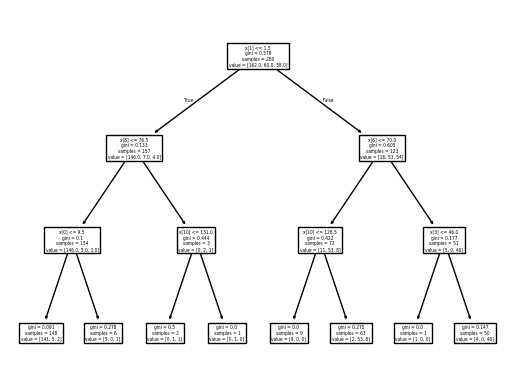

In [99]:
tree.plot_tree(clf_tree)

# Random forests

In [100]:
clf = RandomForestClassifier(
    max_depth=4, 
    random_state=0, 
    n_estimators=200)

In [101]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=0)

In [102]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9321428571428572, 0.8936170212765957)

In [103]:
for name, score in zip(X_col, clf.feature_importances_):
    print(name, score)

SYS 0.12403211532740112
DIA 0.16979261979482646
Gender 0.002996819627566205
Age 0.07386300849083591
Occupation 0.07367408390051279
Sleep Duration 0.021943056336378455
Quality of Sleep 0.07180248892035282
Physical Activity Level 0.0430932659904199
Stress Level 0.04035644425513055
BMI Category 0.04653177814824688
Heart Rate 0.15052712396391
Daily Steps 0.18138719524441899


# Gradient Boosting

In [104]:
gb_clf = GradientBoostingRegressor(max_depth=4, n_estimators=300, learning_rate=0.2)

In [105]:
gb_clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=300)

In [106]:
gb_clf.score(X_train, y_train), gb_clf.score(X_test, y_test)

(0.844210231951142, 0.645574526244852)

In [107]:
for name, score in zip(X_col, gb_clf.feature_importances_):
    print(name, score)

SYS 0.08914661515702535
DIA 0.1295105768661722
Gender 0.00046509505234061736
Age 0.011188459877457993
Occupation 0.031783743164143986
Sleep Duration 0.0005744720056134426
Quality of Sleep 0.0033960932035267395
Physical Activity Level 0.0014380447373012885
Stress Level 0.002237134599745452
BMI Category 0.0006933843705360201
Heart Rate 0.05997322045424621
Daily Steps 0.6695931605118908


In [108]:
gb_clf.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [109]:
gb_clf.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
                              random_state=RandomState(MT19937) at 0x7F9DD635C740)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
       

# Evaluate and Compare Models

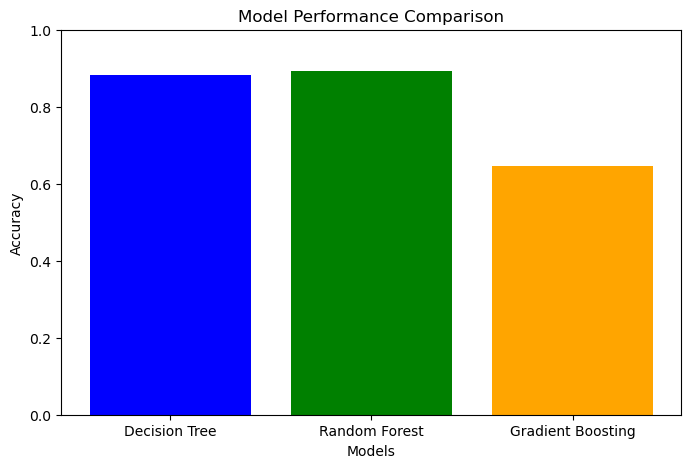

In [ ]:
import matplotlib.pyplot as plt

# Collect model names and scores
models = {
    'Decision Tree': clf_tree.score(X_test, y_test),
    'Random Forest': clf.score(X_test, y_test),
    'Gradient Boosting': gb_clf.score(X_test, y_test)
}

# Plot the scores
plt.figure(figsize=(8, 5))
plt.bar(models.keys(), models.values(), color=['blue', 'green', 'orange'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.show()